<a href="https://colab.research.google.com/github/vishnurapps/LSTM-on-Donors-Choose/blob/master/LSTM_On_Donors_Choose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [72]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import random
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import math
from tqdm import tqdm
import os
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from prettytable import PrettyTable
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1.1 Reading Data

In [74]:
##colab
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"vishnurapps","key":"2fe3b534ce570f26d340570b0fa09617"}'}

In [75]:
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d atifimam/donors-chose
!unzip /content/donors-chose.zip

train_data="/content/train_data.csv"
resources="/content/resources.csv"
glove_vectors="/content/glove_vectors"

donors-chose.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/donors-chose.zip
replace glove_vectors? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# #kaggle
# train_data="/kaggle/input/donors-chose/train_data.csv"
# resources="/kaggle/input/donors-chose/resources.csv"
# glove_vectors="/kaggle/input/donors-chose/glove_vectors"

In [0]:
# ##oakwood
# train_data="../Donor Choose/train_data.csv"
# resources="../Donor Choose/resources.csv"
# glove_vectors="../Donor Choose/glove_vectors"

In [0]:
project_data = pd.read_csv(train_data)
resource_data = pd.read_csv(resources)

In [79]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [80]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


### 1.1 Checking for missing values

In [81]:
# check for missing values in python : https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b
print (project_data.isnull().sum())

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       3
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64


The above output shows that there are missing values in teacher prefix, project_essay_3 and project_essay_4. We can drop the 3 rows having missing teacher prefix. From the description of the project, we know that the numbers of essay submissions were reduced to 2 from 4. So the can ignore the rows having missing project_essay_3 and project_essay_4 as its expected.



In [0]:
# dropna column pandas :https://stackoverflow.com/a/23235618/8363466
project_data = project_data[pd.notnull(project_data['teacher_prefix'])]

In [83]:
# check for missing values in python : https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b
print (project_data.isnull().sum())

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105488
project_essay_4                                 105488
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64


## 1.2 preprocessing of `project_subject_categories`

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.4 Text preprocessing

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [87]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...


In [0]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above stundents 
def preprocessTextData(dataToProcess):
    """This function do the preprocessing of the column text data in essay and title"""
    processedData = []
    # tqdm is for printing the status bar
    for sentance in tqdm(dataToProcess):
        #convert the sentence to lower case before decontracting
        lowersent = sentance.lower()
        sent = decontracted(lowersent)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        processedData.append(sent.strip())
    return processedData


In [91]:
project_data['project_grade_category'] =  project_data['project_grade_category'].str.replace(" ", "_")
project_data['project_grade_category'] =  project_data['project_grade_category'].str.replace("-", "_")
project_data['project_grade_category'].value_counts()

Grades_PreK_2    44225
Grades_3_5       37135
Grades_6_8       16923
Grades_9_12      10962
Name: project_grade_category, dtype: int64

## 1.5 Preparing data for models

In [92]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.5.1 Vectorizing Categorical data

In [0]:
#fitting categorical data using label encoder
def fitCatogarizedData(dataToProcess, vocab = None):
    vectorizer = LabelEncoder()
    vectorizer.fit(dataToProcess)
    return vectorizer

#transforming categorical data using label encoder
def transformCatogarizedData(dataToProcess, vectorizer):
    categories_label = vectorizer.fit_transform(dataToProcess.values.astype(str))
    print("Shape of matrix after label encodig ",categories_label.shape)
    return categories_label

### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

In [0]:
#fitting bag of words
def fitBow(textToProcess):
    # We are considering only the words which appeared in at least 10 documents(rows or projects).
    vectorizer = CountVectorizer(min_df=10, ngram_range=(1, 2), max_features=5000)
    vectorizer.fit(textToProcess)
    return vectorizer
#transforming bag of words
def transformBow(textToProcess, vectorizer):
    processedText = vectorizer.transform(textToProcess)
    print("Shape of matrix after one hot encodig ",processedText.shape)
    return processedText

#### 1.5.2.2 TFIDF vectorizer

In [0]:
#fitting tfidf 
def fitTfidf(textToProcess):
    # We are considering only the words which appeared in at least 10 documents(rows or projects).
    vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2), max_features=5000)
    processedText = vectorizer.fit(textToProcess)
    return vectorizer
#transforming tfidf
def transformTfidf(textToProcess, vectorizer):
    processedText = vectorizer.transform(textToProcess)
    print("Shape of matrix after one hot encodig ",processedText.shape)
    return processedText

#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open(glove_vectors, 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def fitAvgW2V(dataToProcess):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(dataToProcess): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)

    print(len(avg_w2v_vectors))
    print(len(avg_w2v_vectors[0]))
    return avg_w2v_vectors

#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
def fitTfidfw2v(textToProcess):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(textToProcess)
    return tfidf_model

In [0]:
# tfidf Word2Vec
# compute tfidf word2vec for each review.
def transformTfidfw2v(textToProcess, vectorizer):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
    tfidf_words = set(vectorizer.get_feature_names())
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(textToProcess): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return tfidf_w2v_vectors

### 1.5.3 Vectorizing Numerical features

In [0]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
#Minmax Scalar sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#Minmax scalar is used as we need the scaled values to be positive for selectKbest to use chi2
#fitting numerical data
def fitNumerical(dataToProcess):
    numerical_scalar = MinMaxScaler()
    numerical_scalar.fit(dataToProcess)
    return numerical_scalar
#transforming numerical data
def transformNumerical(DataToprocess, scalar):
    return scalar.transform(DataToprocess)

### 1.5.4 Response encoding of catagorical values

In [0]:
#total count
def get_cat_counts(data, label):
    total_cats = np.unique(data[label])
    #print(total_cats)
    total_cats_dict = {}
    for element in total_cats:
        total_cats_dict[element] = (data[label] == element).sum()
        #print(total_cats_dict)
    return total_cats_dict

#print(get_cat_counts(project_data['clean_categories'], 'clean_categories'))

def fit_response(input_data, output, label):
    data = input_data.to_frame()
    data['output'] = output
    response_data = []
    response_data.append(get_cat_counts(data, label))
    response_data.append(get_cat_counts(data[data['output'] == 0], label))
    response_data.append(get_cat_counts(data[data['output'] == 1], label))
    return response_data
# https://www.geeksforgeeks.org/python-check-whether-given-key-already-exists-in-a-dictionary/
# https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
def transform_response(input_data, output, label, response_list):
    data = input_data.to_frame()
    data['output'] = output
    total_dict = response_list[0]
    pos_dict = response_list[1]
    neg_dict = response_list[2]
    pos_prob = []
    neg_prob = []
    #iterte row wise in dataframe
    for index, row in data.iterrows():
        #check if row is present in input dataframe
        if row[label] in total_dict:
            #find probablity of positive and 1 - postitive probablity as negative
            if row[label] in pos_dict:
                pos_prob.append(pos_dict[row[label]]/total_dict[row[label]])
                neg_prob.append(1-(pos_dict[row[label]]/total_dict[row[label]]))
            #add 0 to positive probablity if item is not present. And 1 to negative
            else:
                pos_prob.append(0)
                neg_prob.append(1)
        #if item is not present in the row add equal probablity    
        else :
            pos_prob.append(0.5)
            neg_prob.append(0.5)
        pos_prob_col = np.asarray(pos_prob).reshape(-1,1)
        neg_prob_col = np.asarray(neg_prob).reshape(-1,1)
    return (pos_prob_col, neg_prob_col)

### 1.5.5 Extract number from summary

In [0]:
#check for text in string python : https://stackoverflow.com/a/19859308
def hasNumbers(inputString):
    return any(i.isdigit() for i in inputString)
    

# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V). Here for this set take <b>30K</b> datapoints only. </li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V). Here for this set take <b>30K</b> datapoints only. </li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
          <li> Consider the following range for hyperparameters <b>n_estimators</b> = [10, 50, 100, 150, 200, 300, 500, 1000], 
            <b>max_depth</b> = [2, 3, 4, 5, 6, 7, 8, 9, 10] </li>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using simple cross validation data</li>
    <li>You can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Random Forest and GBDT </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [104]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
print("Size of X_train ", X_train.shape)
print("Size of X_train ", X_test.shape)
print("Size of X_train ", y_train.shape)
print("Size of X_train ", y_test.shape)

Size of X_train  (73194, 19)
Size of X_train  (36051, 19)
Size of X_train  (73194,)
Size of X_train  (36051,)


In [0]:
# type(X_train['project_resource_summary'][10])

In [106]:
X_train.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,quantity
67032,166439,p142905,4123c4ddbcd6e77f580974c661461c7c,Ms.,NY,2017-03-28 18:42:38,Grades_6_8,Support our STEM Exploration Lunch Club!,Working in the poorest congressional district ...,"Last week, my students discovered that the 3D ...",NaN,NaN,"My students need ZomeTools, a bubble kit, and ...",71,Math_Science,AppliedSciences Mathematics,Working in the poorest congressional district ...,363.68,8
96807,171390,p008496,46a929abfe6709a50fc781005c87d183,Mrs.,TX,2016-08-30 19:04:49,Grades_PreK_2,Hands On Learning Is The Way to Go!!,As a teacher and a member of ATPE in a low inc...,My students will be using the magnetic letters...,NaN,NaN,My students need and will become engaged when ...,4,Literacy_Language Math_Science,Literature_Writing Mathematics,As a teacher and a member of ATPE in a low inc...,172.96,5
63213,101787,p138780,84a1ff402e62e8d935789c9de2f5836e,Mrs.,NY,2017-03-28 18:47:51,Grades_3_5,"Learning Should Be \""COOL!\""",I work with students in New York City in a nei...,"No one likes to do anything when they are hot,...",NaN,NaN,My students need an air conditioner for their ...,4,Literacy_Language,Literacy Literature_Writing,I work with students in New York City in a nei...,529.46,1
87964,37365,p241129,85bee7627b940225dc3ddb58e17750f0,Mr.,WA,2016-09-08 18:38:08,Grades_PreK_2,Engaging Books for Young Students,"Our school is highly diverse, with a free and ...",Currently our Kindergartners are able to check...,NaN,NaN,My students need A variety of engaging books f...,64,Literacy_Language,Literacy,"Our school is highly diverse, with a free and ...",397.51,21
10846,178203,p124349,7029347ad328baad6e0d8434f11cc354,Mrs.,MS,2016-10-15 19:28:09,Grades_3_5,Technical Support Please...,My two fifth-grade classes are filled with som...,Chromebooks are very useful in the classroom. ...,NaN,NaN,My students need 4 Chromebooks with headphones...,0,Math_Science,Health_LifeScience Mathematics,My two fifth-grade classes are filled with som...,165.84,5


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:
#Encoding price data    
price_vector = fitNumerical(X_train['price'].values.reshape(-1,1))
price_train = transformNumerical(X_train['price'].values.reshape(-1,1), price_vector).reshape(-1,1)
price_test = transformNumerical(X_test['price'].values.reshape(-1,1), price_vector).reshape(-1,1)

#Encoding quantity data
quantity_vector = fitNumerical(X_train['price'].values.reshape(-1,1))
quantity_train = transformNumerical(X_train['price'].values.reshape(-1,1), quantity_vector).reshape(-1,1)
quantity_test = transformNumerical(X_test['price'].values.reshape(-1,1), quantity_vector).reshape(-1,1)

#Encoding teacher_previously_posted_projects data
previous_projects_vector = fitNumerical(X_train['price'].values.reshape(-1,1))
previous_projects_train = transformNumerical(X_train['price'].values.reshape(-1,1), previous_projects_vector).reshape(-1,1)
previous_projects_test = transformNumerical(X_test['price'].values.reshape(-1,1), previous_projects_vector).reshape(-1,1)

In [0]:
### Encoding of catagorical values

In [109]:
#one hot encoding of clean categories
catagories_vector = fitCatogarizedData(X_train['clean_categories'])
catagories_train = transformCatogarizedData(X_train['clean_categories'], catagories_vector).reshape(-1,1)
catagories_test = transformCatogarizedData(X_test['clean_categories'], catagories_vector).reshape(-1,1)

#one hot encoding of clean sub categories
sub_catagories_vector = fitCatogarizedData(X_train['clean_subcategories'])
sub_catagories_train = transformCatogarizedData(X_train['clean_subcategories'], sub_catagories_vector).reshape(-1,1)
sub_catagories_test = transformCatogarizedData(X_test['clean_subcategories'], sub_catagories_vector).reshape(-1,1)

#one hot encoding of project grade categories
project_grade_vector = fitCatogarizedData(X_train["project_grade_category"])
project_grade_train = transformCatogarizedData(X_train['project_grade_category'], project_grade_vector).reshape(-1,1)
project_grade_test = transformCatogarizedData(X_test['project_grade_category'], project_grade_vector).reshape(-1,1)

#one hot encoding of states
state_vector = fitCatogarizedData(X_train['school_state'])
state_train = transformCatogarizedData(X_train['school_state'], state_vector).reshape(-1,1)
state_test = transformCatogarizedData(X_test['school_state'], state_vector).reshape(-1,1)

#one hot encoding of teacher prefix
teacher_prefix_vector = fitCatogarizedData(X_train['teacher_prefix'])
teacher_prefix_train = transformCatogarizedData(X_train['teacher_prefix'], teacher_prefix_vector).reshape(-1,1)
teacher_prefix_test = transformCatogarizedData(X_test['teacher_prefix'], teacher_prefix_vector).reshape(-1,1)

Shape of matrix after label encodig  (73194,)
Shape of matrix after label encodig  (36051,)
Shape of matrix after label encodig  (73194,)
Shape of matrix after label encodig  (36051,)
Shape of matrix after label encodig  (73194,)
Shape of matrix after label encodig  (36051,)
Shape of matrix after label encodig  (73194,)
Shape of matrix after label encodig  (36051,)
Shape of matrix after label encodig  (73194,)
Shape of matrix after label encodig  (36051,)


In [0]:
# X_test['project_resource_summary'].map(hasNumbers).astype(int)

In [0]:
digit_present_train = X_train['project_resource_summary'].map(hasNumbers)
digit_present_train = digit_present_train.astype(int)
digit_present_test = X_test['project_resource_summary'].map(hasNumbers).astype(int)
digit_present_test = digit_present_test.astype(int)

In [0]:
# X_train.head(1)

In [0]:
# X_train['digits_present'] = X_train['project_resource_summary'].map(hasNumbers).astype(int)
# X_test['digits_present'] = X_test['project_resource_summary'].map(hasNumbers).astype(int)
# X_train['processed_teacher_prefix'] = transformCatogarizedData(X_train['teacher_prefix'], teacher_prefix_vector).reshape(-1,1)

In [0]:
# X_train.head(1)

<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [0]:
# #preprocessing essays
# essay_train = preprocessTextData(X_train['essay'].values)
# essay_test = preprocessTextData(X_test['essay'].values)

# #preprocessing titles
# title_train = preprocessTextData(X_train['project_title'].values)
# title_test = preprocessTextData(X_test['project_title'].values)

In [0]:
# #creating bow essay and title vectors
# essay_bow_vector = fitBow(essay_train)
# bow_essay_train = transformBow(essay_train, essay_bow_vector)
# bow_essay_test = transformBow(essay_test, essay_bow_vector)

# title_bow_vector = fitBow(title_train)
# bow_title_train = transformBow(title_train, title_bow_vector)
# bow_title_test = transformBow(title_test, title_bow_vector)

In [0]:
# #creating tfidf essay and title vectors
# essay_tfidf_vector = fitTfidf(essay_train)
# tfidf_essay_train = transformTfidf(essay_train, essay_tfidf_vector)
# tfidf_essay_test = transformTfidf(essay_test, essay_tfidf_vector)

# title_tfidf_vector = fitTfidf(title_train)
# tfidf_title_train = transformTfidf(title_train, title_tfidf_vector)
# tfidf_title_test = transformTfidf(title_test, title_tfidf_vector)

In [0]:
# #creating avgw2v essay and title vectors
# avgw2v_essay_train = fitAvgW2V(essay_train)
# avgw2v_essay_test = fitAvgW2V(essay_test)
# avgw2v_title_train = fitAvgW2V(title_train)
# avgw2v_title_test = fitAvgW2V(title_test)

In [0]:
# #creating tfidfw2v essay and title vectors
# essay_tfidfw2v_vector = fitTfidfw2v(essay_train)
# tfidfw2v_essay_train = transformTfidfw2v(essay_train, essay_tfidfw2v_vector)
# tfidfw2v_essay_test = transformTfidfw2v(essay_test, essay_tfidfw2v_vector)
# title_tfidfw2v_vector = fitTfidfw2v(title_train)
# tfidfw2v_title_train = transformTfidfw2v(title_train, title_tfidfw2v_vector)
# tfidfw2v_title_test = transformTfidfw2v(title_test, title_tfidfw2v_vector)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["essay"].tolist())
seq_train = tokenizer.texts_to_sequences(X_train["essay"])
seq_test = tokenizer.texts_to_sequences(X_test["essay"])

In [0]:
#https://learn-neural-networks.com/world-embedding-by-keras/
vocab_size = len(tokenizer.word_index) + 1 #if integer data is encoded with values ​​from 0 to 10, then the size of the dictionary will be 11 words.

In [0]:
padded_train = pad_sequences(seq_train,maxlen=800,padding='post', truncating='post')
padded_test = pad_sequences(seq_test, maxlen=800,padding='post', truncating='post')

In [0]:
pickle_in = open("/content/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [0]:
embedding_matrix = zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# input_text = Input(shape=(800,),name="input_text")
embedding_layer = Embedding(vocab_size,300,weights=[embedding_matrix],input_length=800,trainable=False)
input_text = Input(shape=(800,),name="input_text")
x = embedding_layer(input_text)
x = LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x)
flat_1 = Flatten()(x)

In [127]:
X_train.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,quantity
67032,166439,p142905,4123c4ddbcd6e77f580974c661461c7c,Ms.,NY,2017-03-28 18:42:38,Grades_6_8,Support our STEM Exploration Lunch Club!,Working in the poorest congressional district ...,"Last week, my students discovered that the 3D ...",NaN,NaN,"My students need ZomeTools, a bubble kit, and ...",71,Math_Science,AppliedSciences Mathematics,Working in the poorest congressional district ...,363.68,8


In [0]:
# Teacher Prefix
no_of_unique_prefix  = X_train["teacher_prefix"].nunique()
embed_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))

input_prefix = Input(shape=(1,),name="teacher_prefix")
embed_prefix = Embedding(no_of_unique_prefix,embed_size_prefix,trainable=True)(input_prefix)
flat_2 = Flatten()(embed_prefix)
lab_enc = LabelEncoder()
enc_prefix_train = lab_enc.fit_transform(X_train["teacher_prefix"])
X_test["teacher_prefix"] = X_test["teacher_prefix"].map(lambda s: ' ' if s not in lab_enc.classes_ else s)
lab_enc.classes_ = np.append(lab_enc.classes_, ' ')
enc_prefix_test = lab_enc.transform(X_test["teacher_prefix"])

In [0]:
# School State
no_of_unique_state  = X_train["school_state"].nunique()
embed_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))

input_state = Input(shape=(1,),name="school_prefix")
embed_state = Embedding(no_of_unique_state,embed_size_state,name="emb_state",trainable=True)(input_state)
flat_3 = Flatten()(embed_state)
enc_state_train = lab_enc.fit_transform(X_train["school_state"])
enc_state_test = lab_enc.transform(X_test["school_state"])

In [0]:
#project_grade_category
no_of_unique_grade  = X_train["project_grade_category"].nunique()
embed_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))

input_grade= Input(shape=(1,),name="grade_cat")
embed_grade = Embedding(no_of_unique_grade,embed_size_grade,name="emb_grade",trainable=True)(input_grade)
flat_4 = Flatten()(embed_grade)
enc_grade_train = lab_enc.fit_transform(X_train["project_grade_category"])
enc_grade_test = lab_enc.transform(X_test["project_grade_category"])

In [0]:
#project_subject_categories
no_of_unique_subcat  = X_train["clean_categories"].nunique()
embed_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))

input_subcat= Input(shape=(1,),name="sub_cat")
embed_subcat = Embedding(no_of_unique_subcat,embed_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flat_5 = Flatten()(embed_subcat)
lab_enc = LabelEncoder()
enc_subcat_train = lab_enc.fit_transform(X_train["clean_categories"])
X_test["clean_categories"] = X_test["clean_categories"].map(lambda s: ' ' if s not in lab_enc.classes_ else s)
lab_enc.classes_ = np.append(lab_enc.classes_, ' ')
enc_subcat_test= lab_enc.transform(X_test["clean_categories"])

In [0]:
#project_subject_subcategories
no_of_unique_subcat_1  = X_train["clean_subcategories"].nunique()
embed_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embed_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flat_6 = Flatten()(embedding_subcat_1)
lab_enc = LabelEncoder()
enc_subcat_1_train = lab_enc.fit_transform(X_train["clean_subcategories"])
X_test["clean_subcategories"] = X_test["clean_subcategories"].map(lambda s: ' ' if s not in lab_enc.classes_ else s)
lab_enc.classes_ = np.append(lab_enc.classes_, ' ')
enc_subcat_1_test= lab_enc.transform(X_test["clean_subcategories"])

In [0]:
numerical_train_a=digit_present_train.values.reshape(-1, 1)
numerical_train_b=price_train.reshape(-1, 1)
numerical_train_c=quantity_train.reshape(-1, 1)
numerical_train_d=previous_projects_train.reshape(-1, 1)
numerical_test_a=digit_present_test.values.reshape(-1, 1)
numerical_test_b=price_test.reshape(-1, 1)
numerical_test_c=quantity_test.reshape(-1, 1)
numerical_test_d=previous_projects_test.reshape(-1, 1)
numerical_train=np.concatenate((numerical_train_a,numerical_train_b,numerical_train_c,numerical_train_d),axis=1)
numerical_test=np.concatenate((numerical_test_a,numerical_test_b,numerical_test_c,numerical_test_d),axis=1)

from sklearn.preprocessing import StandardScaler
normal=StandardScaler()
normal_train=normal.fit_transform(numerical_train)
normal_test=normal.transform(numerical_test)

In [0]:
numerical_feats = Input(shape=(4,),name="numerical_features")
numerical_featss = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(numerical_feats)

In [0]:
x = concatenate([flat_1,flat_2,flat_3,flat_4,flat_5,flat_6,numerical_featss])
x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_text,input_prefix,input_state,input_grade,input_subcat,input_subcat_1,numerical_feats],outputs=[output])

In [0]:
train_data_1 = [padded_train,enc_prefix_train,enc_state_train,enc_grade_train,enc_subcat_train,enc_subcat_1_train,normal_train]
test_data_1 = [padded_test,enc_prefix_test,enc_state_test,enc_grade_test,enc_subcat_test,enc_subcat_1_test,normal_test]

In [0]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
model_1.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[auroc])

In [0]:
checkpoint_3 = ModelCheckpoint("model_1.h5",monitor="val_auroc",mode="max",save_best_only = True,verbose=1)
NAME = 'model_1'
tensorboard_2 = TensorBoard(log_dir='logss\{}'.format(NAME),update_freq='epoch',batch_size=512)
callbacks_2 = [tensorboard_2,checkpoint_3]

In [141]:
history_1 = model_1.fit(train_data_1,Y_train,batch_size=512,
                        epochs=15,validation_data=(test_data_1,Y_test),verbose=1,callbacks=callbacks_2)

Train on 73194 samples, validate on 36051 samples
Epoch 1/15
73194/73194 [==============================] - 222s 3ms/step - loss: 1.4821 - auroc: 0.5220 - val_loss: 0.9843 - val_auroc: 0.5646

Epoch 00001: val_auroc improved from -inf to 0.56460, saving model to model_1.h5
Epoch 2/15
73194/73194 [==============================] - 221s 3ms/step - loss: 0.8426 - auroc: 0.5991 - val_loss: 0.7400 - val_auroc: 0.7057

Epoch 00002: val_auroc improved from 0.56460 to 0.70568, saving model to model_1.h5
Epoch 3/15
73194/73194 [==============================] - 219s 3ms/step - loss: 0.6613 - auroc: 0.6967 - val_loss: 0.6147 - val_auroc: 0.7412

Epoch 00003: val_auroc improved from 0.70568 to 0.74125, saving model to model_1.h5
Epoch 4/15
73194/73194 [==============================] - 217s 3ms/step - loss: 0.5605 - auroc: 0.7308 - val_loss: 0.5386 - val_auroc: 0.7477

Epoch 00004: val_auroc improved from 0.74125 to 0.74767, saving model to model_1.h5
Epoch 5/15
73194/73194 [=====================

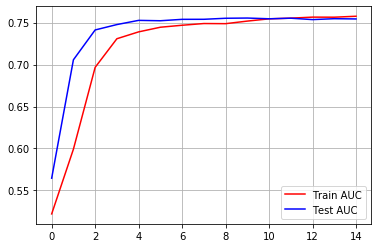

In [144]:
plt.plot(history_1.history['auroc'], 'r')
plt.plot(history_1.history['val_auroc'], 'b')
plt.legend({'Train AUC': 'r', 'Test AUC':'b'})
plt.grid()
plt.show()

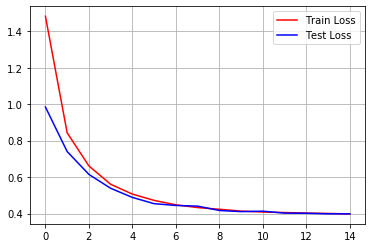

In [145]:
plt.plot(history_1.history['loss'], 'r')
plt.plot(history_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.grid()
plt.show()

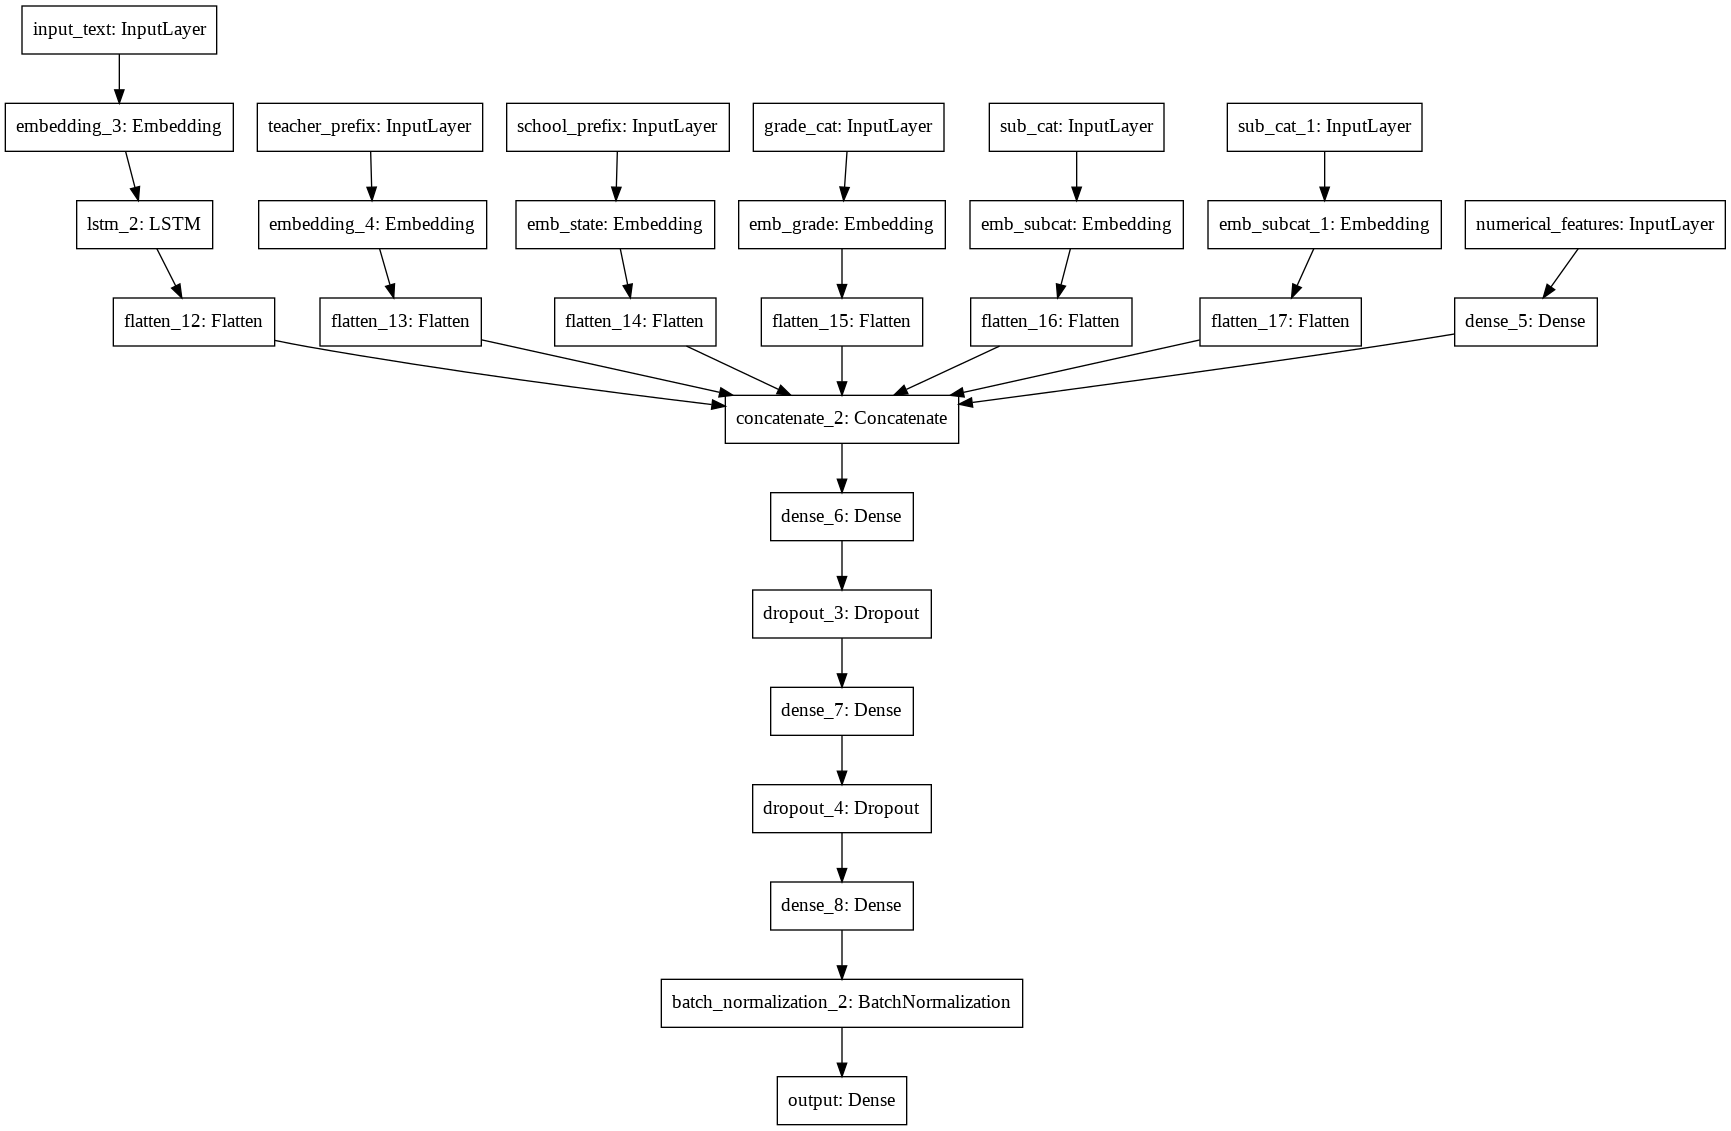

In [146]:
#drawing models
tf.keras.utils.plot_model(
    model_1,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)